# Modeling extreme cases with peaks over threshold - 2
> Technical overview of peaks over threshold

- toc: true 
- badges: true
- comments: true
- author: Gieun Kwak
- categories: [extreme value statistics, peaks over threshold, statistics]

Packages used: <br>`extRemes`, `Rcpp`, `dplyr`

Readings: <br>[An introduction to extreme value statistics](http://grotjahn.ucdavis.edu/EWEs/extremes_primer_v9_22_15.pdf),  <br>[An introduction to statistical modeling of extreme values](https://pdfcoffee.com/anintroductiontostatisticalmodelingofextremevalues-pdf-free.html), <br>[극단치이론을 이용한 VaR의 추정과 검증 : 국내 주식시장을 중심으로](https://academic.naver.com/article.naver?doc_id=30889225)

-----

&emsp;We'll dive right into the analysis of peaks over threshold, using sample data.<br>
As explained before, peaks over threshold method sets a threshold to sort out the data it wants to model. Also, it is a parametric method, meaning that we want to find parameters that would create a distribution that fits the data.
&emsp;Below are the characteristics of peaks over threshold:
- Follows a Generalized Pareto (GP) distribution
- In mathematical terms, $G(y) = 1 - [1 + \frac{\xi (y-\mu)}{\sigma} ]^{\frac{- 1}{\xi}}$
    - $\mu$ is the threshold
    - $\sigma$ is the scale parameter
    - $\xi$ is the shape parameter

In [10]:
options(warn=0)

library(extRemes)
library(Rcpp)
library(ggplot2)
library(dplyr)
library(VGAM)
library(repr)
options(repr.plot.width=10, repr.plot.height=7)

#### The GP distribution looks like this:

Below is the plot where $\sigma$ changes while $\xi=0$

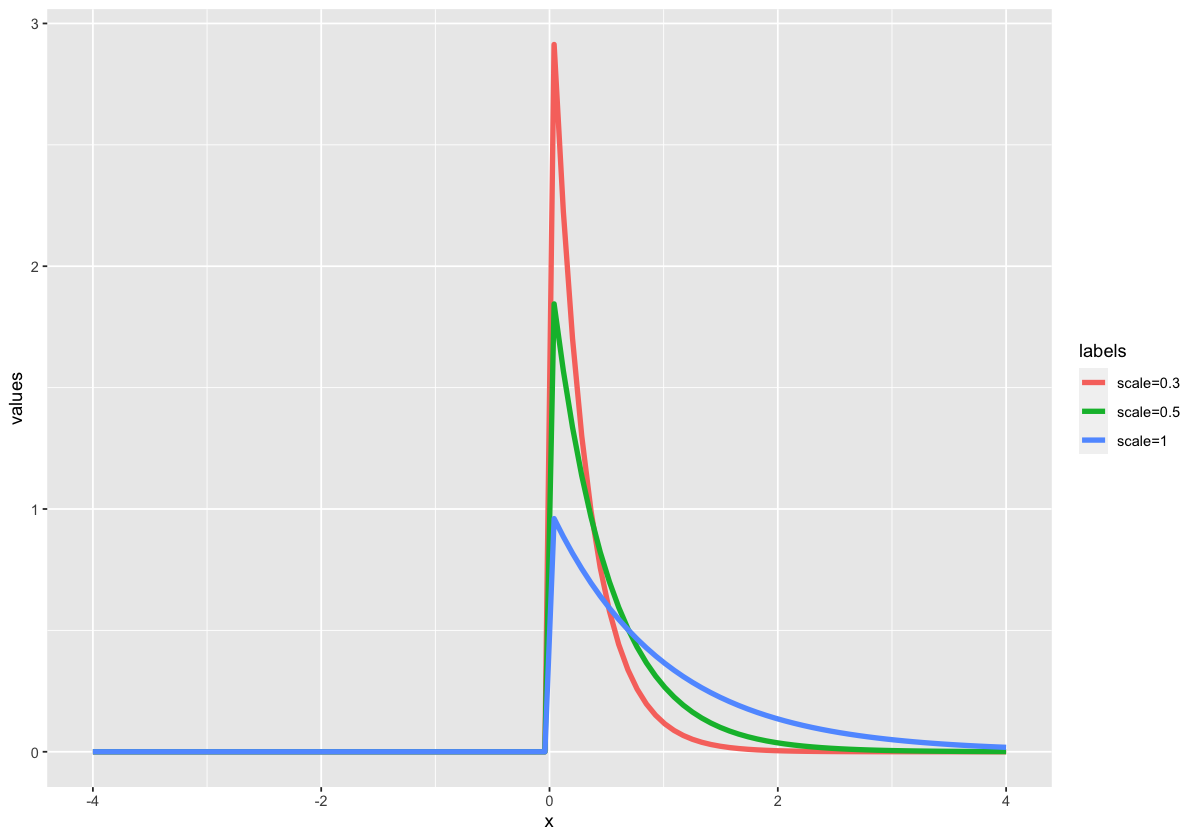

In [12]:
x <- seq(-4, 4, length=100)
y1 <- dgpd(x)
y2 <- dgpd(x, scale=0.5)
y3 <- dgpd(x, scale=0.3)

y = append(y1, y2)
y = append(y, y3)
xs = append(x,x)
xs = append(xs, x)
labels = append(rep_len('scale=1', length(x)), rep_len('scale=0.5', length(x)))
labels = append(labels, rep_len('scale=0.3', length(x)))

df = data.frame('values'=unlist(y))
df['x'] = unlist(xs)
df['labels'] = unlist(labels)

ggplot(df, aes(x=x, y=values, color=labels))+geom_line(size=1.5)

#####################


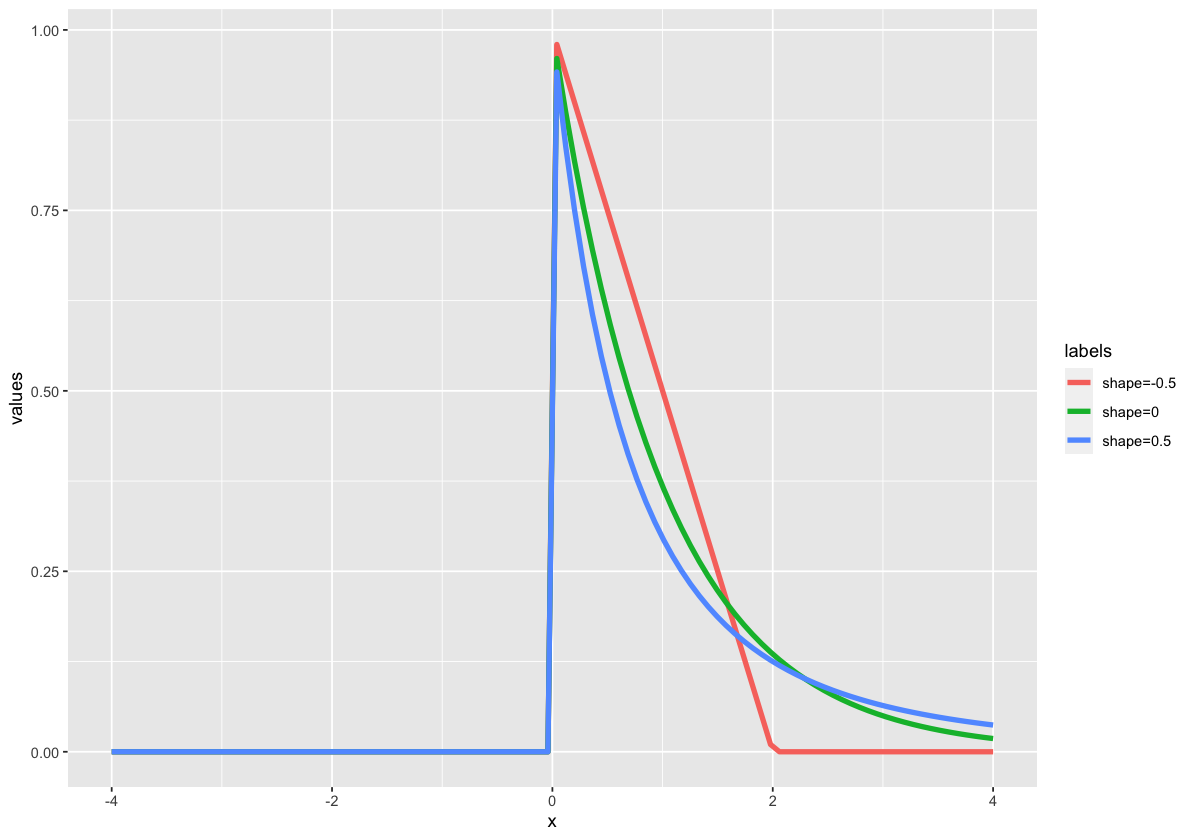

In [13]:
x <- seq(-4, 4, length=100)
y1 <- dgpd(x, shape=-0.5)
y2 <- dgpd(x, shape=0)
y3 <- dgpd(x, shape=0.5)

y = append(y1, y2)
y = append(y, y3)
xs = append(x,x)
xs = append(xs, x)
labels = append(rep_len('shape=-0.5', length(x)), rep_len('shape=0', length(x)))
labels = append(labels, rep_len('shape=0.5', length(x)))

df = data.frame('values'=unlist(y))
df['x'] = unlist(xs)
df['labels'] = unlist(labels)

ggplot(df, aes(x=x, y=values, color=labels))+geom_line(size=1.5)

### - 02. GP distribution

how the distribution looks like.

$$G(y) = 1 - [1 + \frac{\xi (y-\mu)}{\sigma} ]^{\frac{- 1}{\xi}}$$

- $\mu$ is the threshold
- $\sigma$ is the scale parameter
- $\xi$ is the shape parameter

Below is the plot where $\sigma$ changes while $\xi=0$
![](gpd_plot.png "")

Below is the plot where $\xi$ changes while $\sigma=1$
![](gpd_plot2.png "")
If $\xi<0$, it means that this distribution has an upper bound. If $\xi=0$, it becomes $1-exp(-\frac{y}{\tilde{\sigma}})$, which is an exponential distribution. It also means that extremes with lesser magnitudes have a higher probability of occurence than would be seen in distributions where $\xi>0$. In other words, distributions with $\xi>0$ would be a better fit for rainfalls at the very right end of the distribution.

### - 03. Setting the approapriate threshold

Peak over threshold method is very sensitive to the threshold. A small threshold would lead to bias, while a large one could lead to high variance due to small amount of data points.


#### Proposed methods out there

Here are the methods introduces for choosing the appropriate threshold.

| Paper | Proposed way of setting the threshold |
| --- | --- |
| Davison and Smith (1990) / Nefci (2000) | Set it as (standard dev * 1.65) |
| Danielsson and de Vires (1997) | Set threshold based on MSE |
|Cole S. (2001) | Use mean excess graph and Hill graph |
| Massahiro F. and Yasufumi S. (2002) | Value where it divides 4~6% of the total data |
| Christoffersen (2003) | Value where it divides 5% of the total data |
| Embrechts (2003) | Where the excess mean plot is linear |

#### How we will choose the threshold

1. The threshold we want should be between 0.5 year return period and 2year return period.
    - This threshold is set via expert's judgement.

2. Now, to get the specific threshold, we will use the method proposed by Embrechts; finding a threshold where the excess mean plot is linear.
    - Start from the mean of the pareto distribution 
        - $E(y)=\frac{\sigma}{1-\xi}$ where $\xi<1$
    - We hypothesized that the exceedent of $\mu_{0}$ follows a pareto distribution.
        - Then the mean becomes $E(X-\mu_{0}|X>\mu_{0})=\frac{\sigma_{\mu_{0}}}{1-\xi}$
    - If the data points above threshold $\mu$ follows a pareto distribution, it also means that characteristics of pareto distribution should stand all thresholds above $\mu_0$.
        - $E(X-\mu_{0}|X>\mu_{0})=\frac{\sigma_{\mu}}{1-\xi}$ 
        - = $\frac{\sigma_{\mu_{0}}+\xi\mu}{1-\xi}$
    - Thus, we could say that $E(X-\mu_{0}|X>\mu_{0})$ is a linear function of $\mu$. In other words, these estimates are expected to change linearly with $\mu$ when generalized distribution is appropriate.
        - __The appropriate threshold then would be the one where the mean residual life plot is approximately linear in $\mu$__
        - The `mean residual life plot` draws the mean excess for each threshold.

3. Come up with multiple thresholds, and the result could be compared.

#### Comparing the results of different thresholds

As the threshold changes the distribution of the output, the VaR value driven by the distribution will also change. Thus, it is CRITICAL to choose a threshold where the result distribution is stable in order to have a reliable result.
<br><br>
The concept here would be to simply run all the possible experiments and choose the best parameters.

However, in our case, we do not have a lot of data points, and at the same time, we have a specific target, which is to have a good fitting distribution for the extreme values (perhaps, VaR where the return period is over 250y)

We could see the QQ-plot to see if the result follows the result, but it would not be appropriate for multiple experiments.


#### Estimating performance (Back-testing)

In order to see if our distribution properly, we would have to compare the returned value from the distribution with the actual data.

Here, the VaR would be the max rainfall in the defined quantile. Var can be derived from the 


If the distribution correctly represents the data, the percentage of the rainfall exceeding VaR should be equal to the percentage of the rainfall exceeding 1-q(quantile) of the actual data.

Below is an example of a back-testing result
![](back-testing-example.PNG)

Left go through the example for quantile 0.999.
- Lets say the value for 0.999 quantile of the observational data is $a$. There are 7 observations that goes over $a$.
- For GPD distribution where the threshold is 1.7659, lets say the value for 0.999 quantile is $b$. There are 6 observations that goes over $b$
- The GP distribution that is closest to the `(1-q) observations` would be the most appropriate one.

\* Calculating VaR
To calculate the VaR, we start with the GP distribution and the estimated parameters

$\hat F(x) = 1- rate*[1+\frac{\hat \xi}{\hat \sigma}(x-\mu)]^{-\frac{1}{\hat \xi}}$

- $\mu$ is the threshold
- $\sigma$ is the scale parameter
- $\xi$ is the shape parameter
- $rate=\frac{num\;data\;points\;over\;threshold}{num\;data\;points}$

Using the calculation above, the VaR would be:
$VaR_{q} = \mu + \frac{\hat \sigma}{\hat \xi}[ \{ {\frac{1}{rate}(1-q)} \}^{-\xi} -1]$ where $q>F(\mu)$


#### Good to Knows:

- The reason of not comparing the return period estimation with the empirical return period is because the way of calculating the return period for empirical data is not yet tested. The calculation would be different from what we have from the GPD. This will be updated once it is tested.
- When fitting the distribution, since most of the datapoints are closer to the threshold, some distributions might not be a good representation of the extreme cases.
    - ![](not_good_fit.png)

### - 04. Calculating the retirun period

After fitting the distribution we would be able to convert it into a return period.

The return period would be the inverse of $[1 + \frac{\xi (y-\mu)}{\sigma} ]^{\frac{- 1}{\xi}}*rate*ndays$, where $rate=\frac{num\;data\;points\;over\;threshold}{num\;data\;points}$

### - 05. Applying the loading factor

Once we retrieve the return period and the corresponding rainfall(mm), we could calculate the loading factor.
The loading factor would be the percentage between return period from 2c+ simulation and return period from normal simulation.

This loading factor would then be multiplied to the return period derived from Amedas for projection.

--------

## Appendix

__The code for creating distribution plots can be replicated using the following code__
```r
library(extRemes)
library(dplyr)
library(VGAM)
library(ggplot2)

x <- seq(-4, 4, length=100)
y1 <- dgpd(x)
y2 <- dgpd(x, scale=0.5)
y3 <- dgpd(x, scale=0.3)

y = append(y1, y2)
y = append(y, y3)
xs = append(x,x)
xs = append(xs, x)
labels = append(rep_len('scale=1', length(x)), rep_len('scale=0.5', length(x)))
labels = append(labels, rep_len('scale=0.3', length(x)))

df = data.frame('values'=unlist(y))
df['x'] = unlist(xs)
df['labels'] = unlist(labels)

ggplot(df, aes(x=x, y=values, color=labels))+geom_line()

#####################

x <- seq(-4, 4, length=100)
y1 <- dgpd(x, shape=-0.5)
y2 <- dgpd(x, shape=0)
y3 <- dgpd(x, shape=0.5)

y = append(y1, y2)
y = append(y, y3)
xs = append(x,x)
xs = append(xs, x)
labels = append(rep_len('shape=-0.5', length(x)), rep_len('shape=0', length(x)))
labels = append(labels, rep_len('shape=0.5', length(x)))

df = data.frame('values'=unlist(y))
df['x'] = unlist(xs)
df['labels'] = unlist(labels)

ggplot(df, aes(x=x, y=values, color=labels))+geom_line()

```

Relationship between probability and return period<br>
$rp(z,p) = \frac{1}{p}$

1. Create a vector of return levels fror a specified range of test return periods
2. Fina the return level with a corresponding return period that most closely matches the desired return period